In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import torch
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.data.transforms import *


In [3]:
import fastai2

In [4]:
%matplotlib inline

In [5]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 170)
pd.set_option('display.max_colwidth', -1)

/home/auri/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray

In [7]:
class TMA:
    diameter_spot = 1200
    def __init__(self, tma_path, file, img_path_tif):
        self.meta_fn = file
        self.meta_path = tma_path
        self.img_path_tif = img_path_tif
        self.name = file.strip('.txt')[len('TMA results - '):]
        self.spots = self.load_spots_meta()
        self.img_tif = self.load_img_tif()
        
    def load_tma_meta(self):
        df1 = pd.read_csv(os.path.join(self.meta_path, self.meta_fn), names=['fn', 'missing','X', 'Y', 'ID'], sep='\t', skiprows=[0])
        return df1
    
    def load_img_tif(self):
        a = None
        try:
            a = openslide.OpenSlide(os.path.join(self.img_path_tif, self.name + '.tif'))
        except: 
            print(f"BAD {self.name}.tif")
        return a
    
    def load_spots_meta(self):
        spots = []
        for index, rows in self.load_tma_meta().iterrows():
            spots.append(Spot(self.diameter_spot, 
                              rows.fn, rows.missing, (rows.X, rows.Y), rows.ID,
                        self.meta_path, self))
        return spots


In [8]:
class Spot: 
    def __init__(self, diameter, name, missing, center, ID, img_path_jpg, tma):
        self.path_jpg = img_path_jpg
        self.diameter = diameter #in micrometers
        self.name = name
        self.center = center #in micrometers
        self.missing = missing
        self.ID = ID
        self.TMA = tma
        self.tiles = []
        
        
        
    def load_img_jpg(self):
        s = openslide.ImageSlide(os.path.join(self.path_jpg, self.name + '.jpg'))
        #regions to be read with method s.read_region()
        return s
    
    #get spot center coordinates in pixels
    def get_center_pixel(self):
        tma = self.TMA.img_tif
        c_x, c_y = self.center 
        mpp_x, mpp_y = float(tma.properties['openslide.mpp-x']), float(tma.properties['openslide.mpp-y']) #mpp  - 0.25  micras per pixel
        pc_x, pc_y = int(c_x / float(mpp_x)),int(c_y / float(mpp_y))
        return pc_x, pc_y
    
    #return radious in pixels both at full magnification (level = 0) and at a given zoom-out level
    def get_radious_pixel(self, level):
        tma = self.TMA.img_tif
        mpp_x, mpp_y = float(tma.properties['openslide.mpp-x']), float(tma.properties['openslide.mpp-y'])
        #mpp = (mpp_x**2 + mpp_y**2)**0.5
        pspot_radio = int(self.diameter/ mpp_x / 2 )
        pzoom_radio = int( pspot_radio/ 2**level ) #with each increasing level the image is reduced half size 
        return pspot_radio, pzoom_radio
    
    #return spot circunference's north and sud y-coordinates (absolute positions in level 0) 
    #given a relative position from 0 (left) to 1 (right) in the spot diameter in axis x
    def get_circle_coordinates_pixel(self, rel_pos_diameter_x = .5): #return by default the y-coordinates for x fixed at center
        pc_x, pc_y = self.get_center_pixel()
        pspot_radio, _ = self.get_radious_pixel(0)
        x = int(pc_x - pspot_radio + rel_pos_diameter_x*(pspot_radio*2))
        if (( x + pspot_radio < pc_x) or ( x - pspot_radio > pc_x)): #x should be in circle diameter (pc_x - pspot_radio, pc_x + pspot_radio)
            return x, np.nan, np.nan
        root = (pspot_radio**2 - (x - pc_x)**2)**0.5
        y_north = int( -root + pc_y)
        y_sud = int( root + pc_y)
        return x, y_north, y_sud
    
    #check (true or false) if there is scarce tissue in an image
    def check_scarce_tissue(self, tile_image): 
        s = asarray(tile_image)
        return s.mean() >= 230 #completely white = 255
   
    #return an image tile from the spot where x,y is the left-sup corner of the tile
    #for reference for current scanned tifs properties, level 0 is fully magnified image and for level 4 encloses one spot of diameter 1.2 micrometers
    def get_tile(self, x,y , size=(300,300) , level = 4, path = None, tif_name = None):
        tma = None
        if (tif_name == None):
            tma = self.TMA.img_tif
        else:
            try:
                tma = openslide.OpenSlide(os.path.join(path, tif_name + '.tif'))
            except: 
                print(tif_name + '.tif')
        
            
        image = tma.read_region((x,y),level,size)
        if Spot.check_scarce_tissue(Spot, image):
            return np.nan
        else:
            return image

   
        
    
    #check (true or false) that tile (defined by left sup coordinate and size in a zoom level) is enclosed in a box defined by the 4 spot poles 
    def check_tile_in_spot(self, x,y,size=(300,300) , level = 4):
        spot_poles = (self.get_circle_coordinates_pixel(0)[0], #left
                  self.get_circle_coordinates_pixel(1)[0],  #right
                  self.get_circle_coordinates_pixel(0.5)[1], #north
                  self.get_circle_coordinates_pixel(0.5)[2]) #sud
        if (x < spot_poles[0]) or (y < spot_poles[2] ) or (x + size[0]*(2**level) > spot_poles[1] ) or (y + size[1]*(2**level) > spot_poles[3]):
            return False, spot_poles
        else:
            return True, spot_poles
        
        
    #given a tile size in pixels and zoom level then sample all possible tiles from spot 
    #with a given overlap (0 to <1)
    #return all tiles (defined by sup-lef corner coordinates, size and level) 
    #enclosed in box-spot with enough tissue 
    def sample_tiles(self, size = (300,300), level = 4, overlap = .2):
        self.tiles = []
        pspot_radio, _ = self.get_radious_pixel(level)
        spot_tile_ratio = pspot_radio * 2 / size[0] 
        spot_tile_ratio_by_zoom = spot_tile_ratio / 2**level 
        stride_norm = 1 - overlap
        #print(np.arange(0,1,stride_norm/spot_tile_ratio_by_zoom))
        for i_x in np.arange(0,1,stride_norm/spot_tile_ratio_by_zoom): 
            x, y_north, y_sud = self.get_circle_coordinates_pixel(i_x)
            if (y_sud-y_north == 0): #intersection of ecuador with circunference
                if self.check_tile_in_spot(x, int(y_north), size, level)[0]:
                    self.tiles.append([x, int(y_north), size, level])
                if self.check_tile_in_spot(x, int(y_north), size, level)[0]:
                    self.tiles.append([x, int(y_north) - pspot_radio, size, level])
            else:
                for j in np.arange(y_north, y_sud, (y_sud-y_north)*stride_norm/spot_tile_ratio_by_zoom ): 
                    if self.check_tile_in_spot(x, int(j), size, level)[0]:
                        self.tiles.append([x, int(j), size, level])

        return self.tiles
    
    

    #given a zoom level it returns the box enclosing only this spot
    def get_enclosing_box(self, level):
        pspot_radio, pzoom_radio = self.get_radious_pixel(level)
        print(pzoom_radio)
        pc_x, pc_y = spot.get_center_pixel()
        tile = spot.get_tile(pc_x - pspot_radio, pc_y - pspot_radio,  (pzoom_radio * 2, pzoom_radio * 2), level )
        return tile
    

    
        

In [9]:
path = 'SPOTS/TMA06-03.qptma.data/'
df = pd.read_csv('DTS2020 ALENDA.xlsx - DTS2020_ALENDA.csv', )
df_labels = df[['COD_DTS','Epicolon1+2IHQ-IMS-maria paper lynlike_IMS','LynchIMS','ihq_mlh1','dukes_r',
 'TNMagrup','BaseEP1y2actualizada2016-OSCAR-def_n', 'grado_di','infirec','moc',
'edat', 'sexe','ccr_sin','aden_sin','r_beth_4',
'RECIMORT','KRAS','localizacion','fechreci','ILEact','estfseagrup']]

In [10]:
import os
tmas = []
for root, dirs, files in os.walk("SPOTS"):
    for file in files:
        if file.endswith(".txt"):
            tma = TMA(root, file, 'DTS2019')
            tmas.append(tma)
            

            

In [11]:
#generate Dataset 
ds = pd.DataFrame(columns=['tile', 'path','tif_fn', 'patient_ID','label'])

In [12]:
#size = (300,300), level = 3, overlap = .2

label = 'edat'
for tma in tmas:
    for spot in tma.spots:
        for tile in spot.sample_tiles(size = (300,300), level = 1, overlap = .2):
            s = df_labels.loc[df_labels['COD_DTS'] == str(spot.ID)]
            if (s.shape[0] != 0):
                if label == 'edat':
                    l = float(str(s.iloc[0][label]).replace(',','.'))
                else:
                    l = s.iloc[0][label]
                
                if not np.isnan(l):
                    ds = ds.append({'tile': tile, 'path': tma.img_path_tif, 'tif_fn': tma.name, 'patient_ID': spot.ID,'label': l }, ignore_index=True)          




In [13]:
d = ds.merge(df_labels, how='left', left_on='patient_ID',right_on='COD_DTS', )
d = d.loc[d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'].isna() == False]
d.label = d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'].apply(lambda x: x)
d.label = True
d.loc[d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'] == "inestable",'label' ] = False

In [14]:
d.label.describe()

count     50323
unique    2    
top       True 
freq      45583
Name: label, dtype: object

In [15]:
d.shape[0]

50323

tile      [9660, 8548, (300, 300), 1]
path      DTS2019                    
tif_fn    TMA06-12                   
Name: 51127, dtype: object
(300, 300, 4)


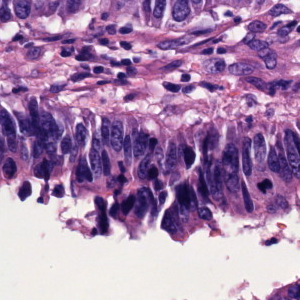

In [16]:
j = 567
print((d.iloc[j][['tile','path', 'tif_fn']]))
p = Spot.get_tile(Spot, *(d.iloc[j].tile), path = d.iloc[j].path, tif_name = d.iloc[j].tif_fn)
print(np.array(p).shape)
p

In [17]:
import torch
print(np.max(np.array(p)[:,:,3]))
p1 = np.array(p)[:,:,:3]


img = np.array(p)[:,:,:3]
t = torch.Tensor(np.array(img))
t= t.permute(2,0,1).float()/255.0
t.shape,t

255


(torch.Size([3, 300, 300]),
 tensor([[[0.6784, 0.6824, 0.4196,  ..., 0.9529, 0.9490, 0.9333],
          [0.6941, 0.6863, 0.4706,  ..., 0.9529, 0.9608, 0.9333],
          [0.6941, 0.6392, 0.4902,  ..., 0.9412, 0.9333, 0.9294],
          ...,
          [0.9216, 0.9255, 0.9333,  ..., 0.2078, 0.2000, 0.1843],
          [0.9216, 0.9294, 0.9333,  ..., 0.2157, 0.2549, 0.2745],
          [0.9333, 0.9333, 0.9373,  ..., 0.2510, 0.2588, 0.3333]],
 
         [[0.5373, 0.5373, 0.2784,  ..., 0.8745, 0.8706, 0.8510],
          [0.5529, 0.5490, 0.3255,  ..., 0.9098, 0.9333, 0.9098],
          [0.5725, 0.5137, 0.3451,  ..., 0.9216, 0.9255, 0.9255],
          ...,
          [0.9412, 0.9333, 0.9333,  ..., 0.1294, 0.1137, 0.0980],
          [0.9412, 0.9373, 0.9333,  ..., 0.1333, 0.1725, 0.1725],
          [0.9333, 0.9333, 0.9333,  ..., 0.1255, 0.1451, 0.2118]],
 
         [[0.7882, 0.8000, 0.5529,  ..., 0.9176, 0.9176, 0.9255],
          [0.7922, 0.8000, 0.5961,  ..., 0.9412, 0.9608, 0.9490],
          [0

In [18]:
idxs = np.random.permutation(range(d.shape[0]))
cut = int(0.8 * d.shape[0])
train_files = d.iloc[idxs[:cut]]
valid_files = d.iloc[idxs[cut:]]
valid_files

,tile,path,tif_fn,patient_ID,label,COD_DTS,Epicolon1+2IHQ-IMS-maria paper lynlike_IMS,LynchIMS,ihq_mlh1,dukes_r,TNMagrup,BaseEP1y2actualizada2016-OSCAR-def_n,grado_di,infirec,moc,edat,sexe,ccr_sin,aden_sin,r_beth_4,RECIMORT,KRAS,localizacion,fechreci,ILEact,estfseagrup
102561,"[56660, 7668, (300, 300), 1]",DTS2019,TMA14-06,06-6798-6,True,06-6798-6,estable,esporadico,positiu,II,II,0,"bien, mod",no,no,"84,08",Mujer,no,NaN,no,no,KRAS mutado,dcho,.,2393.0,vivo
72770,"[21980, 13652, (300, 300), 1]",DTS2019,TMA08-18,E384,True,E384,estable,esporadico,positiu,II,II,0,"bien, mod",sí,no,"84,74",Hombre,no,NaN,no,si,KRAS WT,izq,.,755.0,muerto
82523,"[9200, 10180, (300, 300), 1]",DTS2019,TMA08-37,E05683,True,E05683,estable,esporadico,positiu,III,III,1,"bien, mod",no,no,"64,3",Mujer,no,NaN,no,no,KRAS WT,izq,.,1963.0,vivo
72040,"[34340, 87348, (300, 300), 1]",DTS2019,TMA08-17,E2342,True,E2342,estable,esporadico,positiu,III,III,1,"bien, mod",sí,no,"76,84",Hombre,no,NaN,no,si,KRAS WT,dcho,01.11.2010,1447.0,vivo
74322,"[17360, 58319, (300, 300), 1]",DTS2019,TMA08-18,E4149,True,E4149,estable,esporadico,positiu,III,III,1,"bien, mod",no,sí,"77,45",Mujer,no,NaN,no,no,no valorable,dcho,.,2143.0,vivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93305,"[38080, 50712, (300, 300), 1]",DTS2019,TMA08-68,1082,True,1082,estable,esporadico,positiu,I,I,0,"bien, mod",sí,no,"71,23",Mujer,no,NaN,no,.,KRAS WT,izq,.,1.0,perdido
77069,"[33900, 76440, (300, 300), 1]",DTS2019,TMA08-33,E02722,True,E02722,estable,esporadico,positiu,NaN,NaN,NaN,NaN,NaN,NaN,"66,34",Hombre,no,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
50730,"[39760, 4280, (300, 300), 1]",DTS2019,TMA06-12,4035,True,4035,estable,esporadico,positiu,II,NaN,NaN,mal,no,sí,"74,39",Mujer,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN
74053,"[23440, 53419, (300, 300), 1]",DTS2019,TMA08-18,E384,True,E384,estable,esporadico,positiu,II,II,0,"bien, mod",sí,no,"84,74",Hombre,no,NaN,no,si,KRAS WT,izq,.,755.0,muerto


In [19]:
class TileDataset(torch.utils.data.Dataset):
    def __init__(self, df, is_valid=False):
        self.tiles,self.is_valid = df,is_valid
        
    def __getitem__(self, i):
        self.tiles
        
        img = Spot.get_tile(Spot, *(self.tiles.iloc[i].tile), path = self.tiles.iloc[i].path, tif_name = self.tiles.iloc[i].tif_fn)
        #print(img)
        if (isinstance(img, Image.Image) == False): 
            i = j
            img = Spot.get_tile(Spot, *(self.tiles.iloc[i].tile), path = self.tiles.iloc[i].path, tif_name = self.tiles.iloc[i].tif_fn)
        
        img = np.array(img)[:,:,:3]
        t = torch.Tensor(np.array(img))
        t = t.permute(2,0,1).float()/255.0
        
        label = torch.Tensor([self.tiles.iloc[i].label]).squeeze()
        return (TensorImage(t), label)
    
    def __len__(self): return self.tiles.shape[0]
        
        

In [20]:
train_ds = TileDataset(train_files)
valid_ds = TileDataset(valid_files, is_valid=True)

In [21]:
from fastai2.data.core import DataLoaders

In [22]:
dls = DataLoaders.from_dsets(train_ds, valid_ds,device=default_device(),
                            after_batch=[Normalize.from_stats(*imagenet_stats), ])

In [23]:
b = dls.one_batch()

In [25]:
#b[0]

In [26]:
explode_types(b)

{tuple: [fastai2.torch_core.TensorImage, torch.Tensor]}

In [27]:
#learn = cnn_learner(dls, resnet34,config={'ps':0.}, loss_func=MSELossFlat(),metrics=mse,n_out=1)
learn = cnn_learner(dls, resnet34,config={'ps':0.}, loss_func=BCEWithLogitsLossFlat() ,metrics=error_rate ,n_out=1)

In [28]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 300 x 300'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 150 x 150  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 150 x 150  128        True      
________________________________________________________________
ReLU                 64 x 64 x 150 x 150  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 75 x 75    0          False     
________________________________________________________________
Conv2d               64 x 64 x 75 x 75    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 75 x 75    128        True      
________________________________________________________________
ReLU                 64 x 64 x 75 x 75    0          False     
_________________________________________________

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

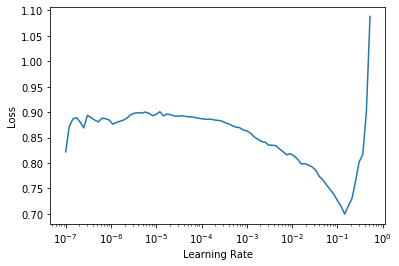

In [29]:
learn.lr_find()

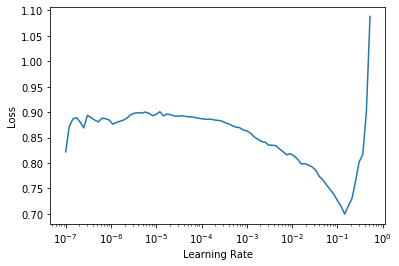

In [30]:
learn.recorder.plot_lr_find()

In [ ]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,error_rate,time


In [ ]:
dls[1].dataset[0]

In [ ]:
dls[1].dataset[0]

In [ ]:
learn.get_preds()[1].shape

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.__dict__


In [ ]:
interp.losses.shape

In [ ]:
tma = tmas[1]

print(tma.meta_path)
print(tma.img_path_tif)

print(tma.spots[2].center)
spot = tma.spots[5]
jpg = spot.load_img_jpg()
tif = tma.load_img_tif()
tif

In [ ]:
tma.img_tif.properties
print(spot.TMA.name)
print(spot.name)
print(spot.ID)
print(spot.diameter)
spot.get_center_pixel()
print(spot.get_radious_pixel(0))
print(spot.get_circle_coordinates_pixel(0))
print(spot.check_tile_in_spot(41100, spot.get_circle_coordinates_pixel(0)[1] - spot.get_radious_pixel(0)[0]))
spot.get_tile(41100, spot.get_circle_coordinates_pixel(0)[1] - spot.get_radious_pixel(0)[0])

In [ ]:
img = spot.get_enclosing_box(4)
print(img.size)
img

In [ ]:
spot.tiles = []
print(len(spot.tiles))
for t in spot.sample_tiles(size = (300,300), level = 2, overlap = .3):
    print(t)
    

In [ ]:
print(len(spot.tiles))
print(spot.tiles[1])

In [ ]:
plt.imshow(spot.get_tile(*spot.tiles[0]))

In [ ]:
spot.get_tile(*spot.tiles[0])

In [ ]:
tma.img_tif.properties